# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import AsynchronousXopt as Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

# Nicer plotting
%config InlineBackend.figure_format = 'retina'


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """

max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.gc3b7c41
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

106 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 3.54 s, sys: 28.4 ms, total: 3.57 s
Wall time: 1min 45s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.6 s, sys: 163 ms, total: 3.77 s
Wall time: 26.2 s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time
X = Xopt(YAML)

with ThreadPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.41 s, sys: 55.5 ms, total: 3.46 s
Wall time: 25.5 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.dump('test.yaml') # Write this input to file
!cat test.yaml

data: null
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [11]:
%%time
!mpirun -n 8 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2, asynchronous=True)
Parallel execution with 8 workers
Enabling async mode
Initialized generator cnsga
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2



            Xopt
________________________________
Version: 0+untagged.1.gc3b7c41
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159




Xopt is done. Max evaluations 1000 reached.


CPU times: user 211 ms, sys: 61.6 ms, total: 272 ms
Wall time: 23.7 s


In [12]:
!tail xopt.log

2024-04-03T03:53:40+0000 - xopt - INFO - Parallel execution with 8 workers
2024-04-03T03:53:40+0000 - xopt - INFO - Enabling async mode
2024-04-03T03:53:40+0000 - xopt.generator - INFO - Initialized generator cnsga
2024-04-03T03:53:40+0000 - xopt.generators.ga.cnsga - INFO - Created toolbox with 2 variables, 2 constraints, and 2 objectives.
2024-04-03T03:53:40+0000 - xopt.generators.ga.cnsga - INFO -     Using selection algorithm: nsga2
2024-04-03T03:54:00+0000 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43259,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:36483,Total threads: 1
Dashboard: http://127.0.0.1:33279/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:46493,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 8.3 s, sys: 819 ms, total: 9.12 s
Wall time: 30.6 s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
3,1.238134,2.814100,dummy_constant,1.238134,2.814100,8.358151,5.899902,0.040848,False
1,1.935903,0.243628,dummy_constant,1.935903,0.243628,2.848963,2.127542,0.136026,False
2,1.680501,1.499073,dummy_constant,1.680501,1.499073,4.010084,2.391728,0.148983,False
3,1.624992,2.389359,dummy_constant,1.624992,2.389359,7.448779,4.835286,0.193441,False
4,0.408644,2.734847,dummy_constant,0.408644,2.734847,6.718278,5.002885,0.112797,False
...,...,...,...,...,...,...,...,...,...
995,0.129748,1.040879,dummy_constant,0.129748,1.040879,0.140438,0.429637,0.097841,False
996,0.788533,0.191894,dummy_constant,0.788533,0.191894,-0.263501,0.178181,0.177623,False
997,0.276720,0.987686,dummy_constant,0.276720,0.987686,0.085608,0.287691,0.053324,False
998,0.361471,0.830995,dummy_constant,0.361471,0.830995,-0.274848,0.128748,0.028747,False


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error,feasible_c1,feasible_c2,feasible
7,0.952515,0.783884,dummy_constant,0.952515,0.783884,0.519578,0.285360,0.059842,False,True,True,True
40,0.485686,1.198753,dummy_constant,0.485686,1.198753,0.573668,0.488461,0.076405,False,True,True,True
57,1.063423,0.861580,dummy_constant,1.063423,0.861580,0.883247,0.448186,0.015970,False,True,True,True
128,0.952515,0.598942,dummy_constant,0.952515,0.598942,0.356340,0.214559,0.005645,False,True,True,True
130,0.926572,0.852377,dummy_constant,0.926572,0.852377,0.506511,0.306134,0.165865,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
993,1.002489,0.901888,dummy_constant,1.002489,0.901888,0.751970,0.414009,0.127933,False,True,True,True
994,0.526540,0.894033,dummy_constant,0.526540,0.894033,0.138016,0.155967,0.075321,False,True,True,True
995,0.129748,1.040879,dummy_constant,0.129748,1.040879,0.140438,0.429637,0.097841,False,True,True,True
997,0.276720,0.987686,dummy_constant,0.276720,0.987686,0.085608,0.287691,0.053324,False,True,True,True


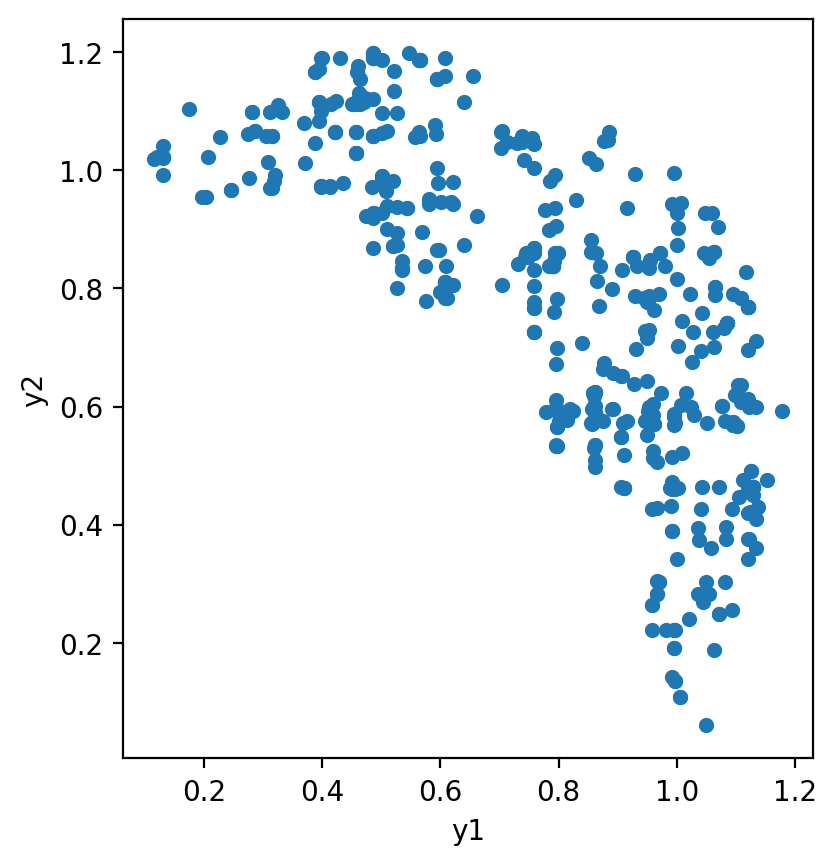

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

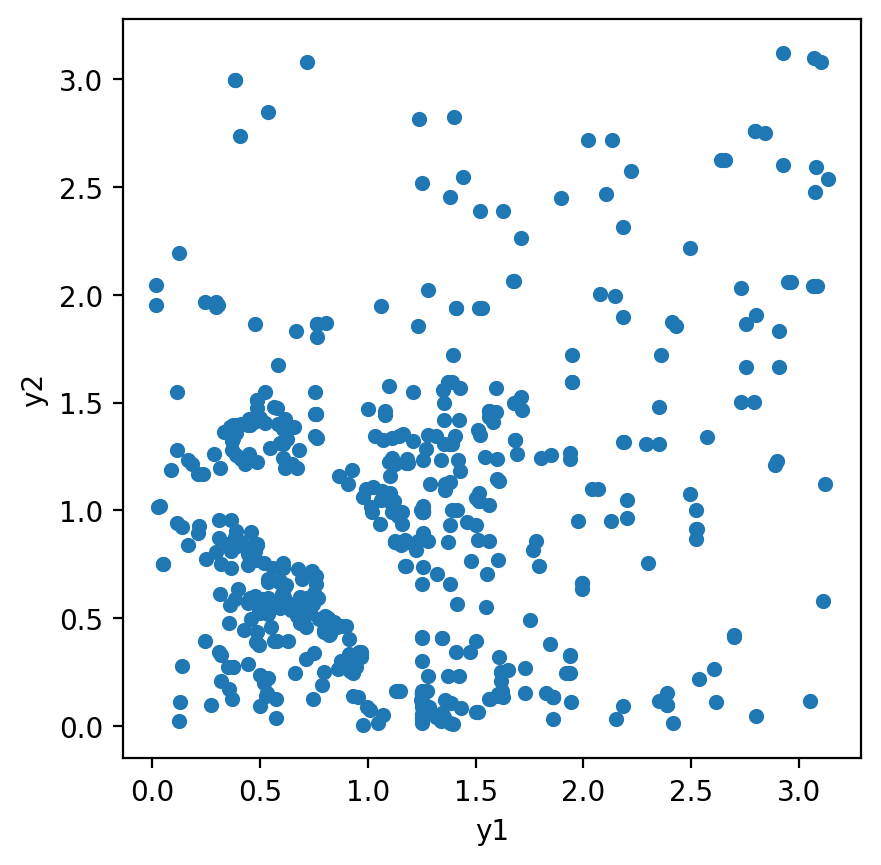

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

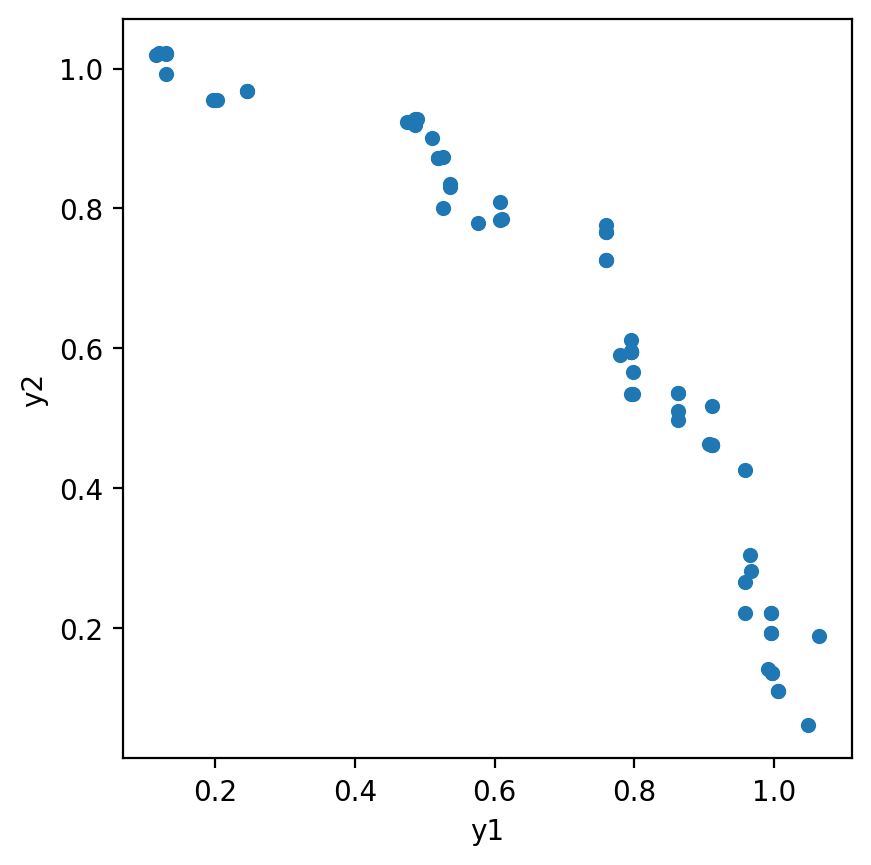

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

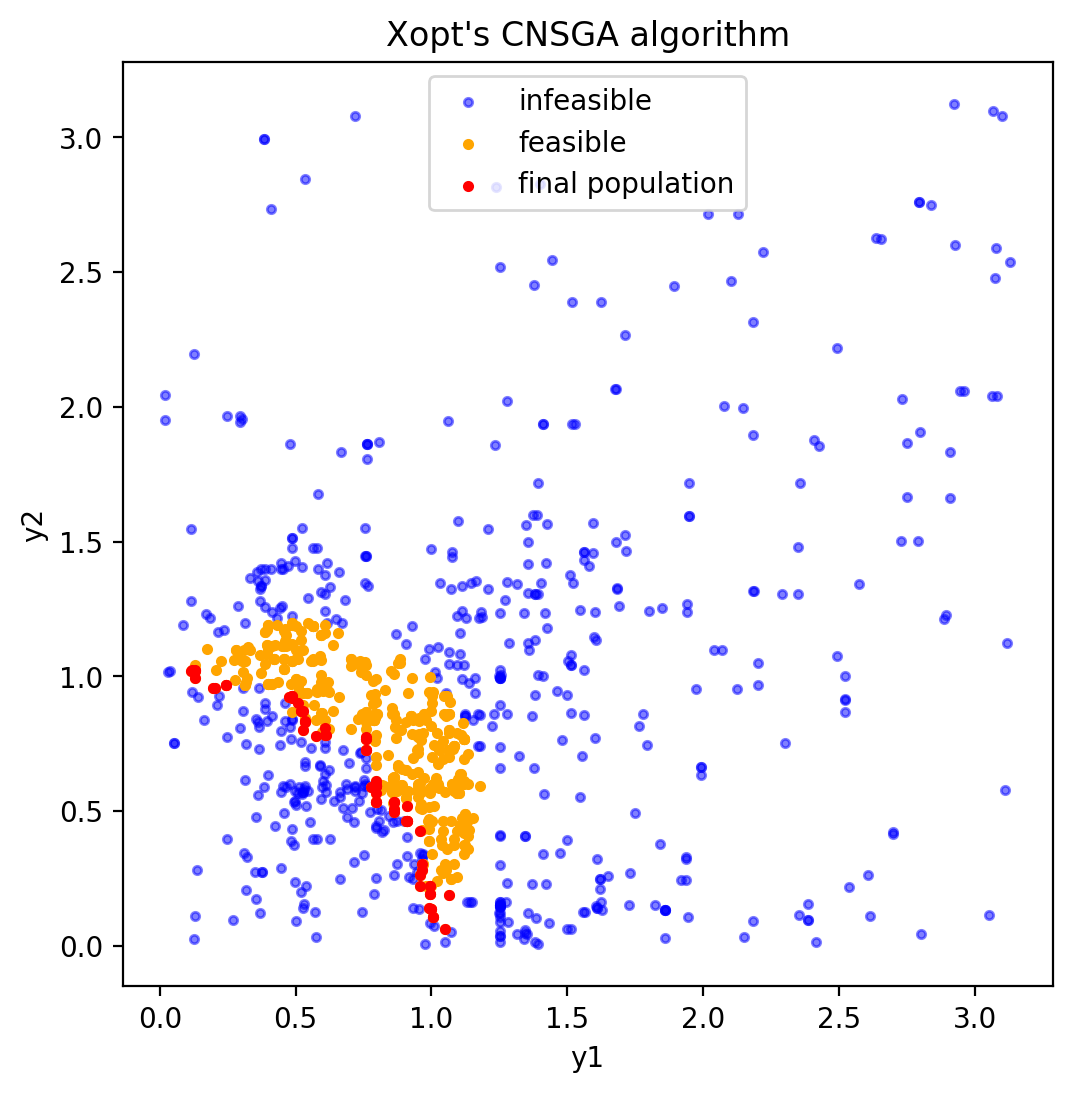

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
#!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml